In [27]:
#%% 
import xarray as xr
from PyCO2SYS import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import pandas as pd

from cProfile import label
from json import load
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from PyCO2SYS import sys
from scipy.io import loadmat
import warnings
warnings.filterwarnings("ignore")

import warnings

# 3rd party libraries
import statsmodels.api as sm
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.feature as cfeature

from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
import scipy

projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))

In [2]:
#%%
yr_min = 1993
yr_max = 2021+1
time_min = np.datetime64('1993-01-01')
time_max = np.datetime64('2021-12-31')
lon_min = -170
lon_max = -40
lat_min = 10
lat_max = 65
#%%
def calc_clim_anom(ts):
    ts_reshape = np.reshape(ts,[np.int64(len(ts)/12),12])
    ts_detrend = scipy.signal.detrend(ts,axis=0)
    ts_detrend_reshape = np.reshape(ts_detrend,ts_reshape.shape)
    clim = np.nanmean(ts_detrend_reshape,axis=0)
    ts_anom = ts_reshape - clim
    ts_anom = np.reshape(ts_anom,ts.shape)
    return clim,ts_anom
n_yr = np.int64(yr_max-yr_min)

In [3]:
def bin_counts(x,y,xlim,ylim,step):
    x_new = np.arange(xlim[0],xlim[1]+step/2,step)
    y_new = np.arange(ylim[0],ylim[1]+step/2,step)

    dens = np.full((len(y_new),len(x_new)),np.nan)
    for idxx in range(len(x_new)):
        for idxy in range(len(y_new)):
            n = np.sum((x>=x_new[idxx]-step/2) & (x<x_new[idxx]+step/2) & (y>=y_new[idxy]-step/2) & (y<y_new[idxy]+step/2))
            if n>0:
                dens[idxx,idxy] = np.copy(n)
    return dens,x_new,y_new

regions_list = ['mask_GStL','mask_SS','mask_GoMe','mask_MAB','mask_SAB','mask_GoMx']
regions_name = ['GStL & GB','SS','GoME','MAB','SAB','GoMX']

In [4]:
file_socat = '/Volumes/Crucial_4T/carbon/SOCAT/v2023/SOCATv2023_qrtrdeg_gridded_coast_monthly.nc'
ds_socat = xr.open_dataset(file_socat)
lon_socat = ds_socat.xlon.values
lat_socat = ds_socat.ylat.values
time_socat = ds_socat.tmnth.values
idxx = np.where((lon_socat>=lon_min) & (lon_socat<=lon_max))[0]
idxy = np.where((lat_socat>=lat_min) & (lat_socat<=lat_max))[0]
idxt = np.where((time_socat>=time_min) & (time_socat<=time_max))[0]
lon_socat = lon_socat[idxx]
lat_socat = lat_socat[idxy]
time_socat = time_socat[idxt]
fco2_socat = ds_socat.coast_fco2_ave_weighted[idxt,idxy,idxx].values
sst_socat = ds_socat.coast_sst_ave_weighted[idxt,idxy,idxx].values
sss_socat = ds_socat.coast_salinity_ave_weighted[idxt,idxy,idxx].values
fco2_socat[(fco2_socat>1000)|(fco2_socat<1)] = np.nan
sst_socat[(sst_socat>100)|(sst_socat<-4)] = np.nan
sss_socat[(sss_socat>100)|(sss_socat<0)] = np.nan
fco2_socat_4d = np.reshape(fco2_socat,(np.int64(fco2_socat.shape[0]/12),12,fco2_socat.shape[1],fco2_socat.shape[2]))
fco2_socat_std = ds_socat.coast_fco2_std_weighted[idxt,idxy,idxx].values
N_counts = ds_socat.coast_fco2_count_nobs[idxt,idxy,idxx].values

fco2_socat_std[fco2_socat_std<0.001] = np.nan
N_counts[N_counts<=4] = np.nan

In [5]:
#%% SST
file_sst = '/Volumes/Crucial_4T/SST/OISST_v2.1/oisst-avhrr-v02r01.19810901.nc'
ds_sst = xr.open_dataset(file_sst)
lon_sst = ds_sst.lon.values
lat_sst = ds_sst.lat.values
idxlon = np.where((lon_sst>=lon_min+360)&(lon_sst<=lon_max+360))[0]
idxlat = np.where((lat_sst>=lat_min)&(lat_sst<=lat_max))[0]
sst_oisst_err_4d = np.full((n_yr,12,len(lat_socat),len(lon_socat)),np.nan)
for yr in range(yr_min,yr_max):
    for mon in range(1,13):
        idxt = np.int64((yr-yr_min)*12+mon-1)
        files_sst = glob('/Volumes/Crucial_4T/SST/OISST_v2.1/oisst-avhrr-v02r01.'+str(yr)+str(mon).zfill(2)+'*.nc')
        sst_err_i = np.full((len(files_sst),len(idxlat),len(idxlon)),np.nan)
        for idxf in range(len(files_sst)):
            file_sst = files_sst[idxf]
            ds_sst = xr.open_dataset(file_sst)
            sst_err_i[idxf] = ds_sst.err[:,:,idxlat,idxlon].values
        sst_oisst_err_4d[yr-yr_min,mon-1] = np.nanmean(sst_err_i,axis=0)
sst_oisst_err_3d = sst_oisst_err_4d.reshape(fco2_socat.shape)

In [6]:
file_product = '/Volumes/Crucial_4T/carbon/Hybrid-NAC-pCO2/ReCAD-NAC-pCO2_v3.nc'
ds_product = xr.open_dataset(file_product)
lon_product = ds_product.lon.values
lat_product = ds_product.lat.values
time_product = ds_product.time.values
fco2_product = ds_product.fco2_product.values
fco2_product_4d = np.reshape(fco2_product,(np.int64(fco2_product.shape[0]/12),12,fco2_product.shape[1],fco2_product.shape[2]))
# fco2_product_raw = ds_product.fco2_product.values
# fco2_product_raw_4d = np.reshape(fco2_product_raw,(np.int64(fco2_product.shape[0]/12),12,fco2_product.shape[1],fco2_product.shape[2]))

# %%
def get_clim_anom(ts):
    ts_clim = np.nanmean(np.reshape(ts,(np.int64(len(ts)/12),12)),axis=0)
    ts_anom = ts - np.repeat(ts_clim,np.int64(len(ts)/12))
    return ts_clim, ts_anom

In [19]:
lat_msh, lon_msh = np.meshgrid(lat_socat,lon_socat,indexing='ij')
file_topo = '/Volumes/Crucial_4T/etopo/ETOPO2/ETOPO2v2c_f4.nc'
ds_topo = xr.open_dataset(file_topo)
depth_wide = ds_topo.z.interp(x=lon_socat,y=lat_socat).values

mask_wide = dict({})

mask_wide['mask_GoMeSS'] = np.float64((lon_msh>-70)&(lon_msh<=-60)&(lat_msh>=41.5)&(lat_msh<=46))
mask_wide['mask_GoMeSS'][mask_wide['mask_GoMeSS']<0.5] = np.nan
mask_wide['mask_GoMeSS'] = np.repeat(np.reshape(mask_wide['mask_GoMeSS'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_GoMeSS'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_GoMe'] = np.float64((lon_msh>-71)&(lon_msh<=-65.5)&(lat_msh>=30)&(lat_msh<=46))
mask_wide['mask_GoMe'][mask_wide['mask_GoMe']<0.5] = np.nan
mask_wide['mask_GoMe'] = np.repeat(np.reshape(mask_wide['mask_GoMe'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_GoMe'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_SS'] = np.float64((lon_msh>-65.5)&(lon_msh<=-60)&(lat_msh>=37)&(lat_msh<=46))
mask_wide['mask_SS'][mask_wide['mask_SS']<0.5] = np.nan
mask_wide['mask_SS'] = np.repeat(np.reshape(mask_wide['mask_SS'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_SS'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_GStL'] = np.float64((lon_msh>-69)&(lon_msh<=-45)&(lat_msh>=41.5)&(lat_msh<=51))
mask_wide['mask_GStL'][mask_wide['mask_GStL']<0.5] = np.nan
mask_wide['mask_GStL'] = np.repeat(np.reshape(mask_wide['mask_GStL'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_GStL'][mask_wide['mask_GoMeSS']>0.5] = np.nan
mask_wide['mask_GStL'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_SAB'] = np.float64((lon_msh>=-82)&(lon_msh<=-70)&(lat_msh>=27)&(lat_msh<=35.5))
mask_wide['mask_SAB'][mask_wide['mask_SAB']<0.5] = np.nan
mask_wide['mask_SAB'] = np.repeat(np.reshape(mask_wide['mask_SAB'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_SAB'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_MAB'] = np.float64((lon_msh>=-82)&(lon_msh<=-70)&(lat_msh>=35.5)&(lat_msh<=41.5))
mask_wide['mask_MAB'][mask_wide['mask_MAB']<0.5] = np.nan
mask_wide['mask_MAB'] = np.repeat(np.reshape(mask_wide['mask_MAB'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_MAB'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_GoMx'] = np.float64((lon_msh>=-100)&(lon_msh<=-80)&(lat_msh>=17)&(lat_msh<=31))
mask_wide['mask_GoMx'][mask_wide['mask_GoMx']<0.5] = np.nan
x1 = -83; y1 = 31; x2 = -81; y2 =25.5
a = (y2-y1)/(x2-x1)
b = y2-a*x2
mask_wide['mask_GoMx'][(a*lon_msh+b)<lat_msh] = np.nan
x1 = -87.0; y1 = 21; x2 = -80.5; y2 =25
a = (y2-y1)/(x2-x1)
b = y2-a*x2
mask_wide['mask_GoMx'][(a*lon_msh+b)>lat_msh] = np.nan
mask_wide['mask_GoMx'][(lon_msh<=-89.75) & (lat_msh>=29.5)] = np.nan
mask_wide['mask_GoMx'] = np.repeat(np.reshape(mask_wide['mask_GoMx'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_GoMx'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_CbS'] = np.float64((lon_msh>=-90)&(lon_msh<=-55)&(lat_msh>=15)&(lat_msh<=27))
mask_wide['mask_CbS'][mask_wide['mask_CbS']<0.5] = np.nan
mask_wide['mask_CbS'] = np.repeat(np.reshape(mask_wide['mask_CbS'],(1,len(lat_product),len(lon_product))),len(time_product),axis=0)
mask_wide['mask_CbS'][~np.isnan(mask_wide['mask_GoMx'])] = np.nan
mask_wide['mask_CbS'][~np.isnan(mask_wide['mask_SAB'])] = np.nan
mask_wide['mask_CbS'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_Atlantic'] = np.float64((~np.isnan(mask_wide['mask_GoMx']) + ~np.isnan(mask_wide['mask_SAB']) + ~np.isnan(mask_wide['mask_MAB']) + ~np.isnan(mask_wide['mask_GoMe']) + ~np.isnan(mask_wide['mask_SS']) + ~np.isnan(mask_wide['mask_GStL']))>0)
mask_wide['mask_Atlantic'][mask_wide['mask_Atlantic']<0.5] = np.nan
mask_wide['mask_Atlantic'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_Atlantic_north'] = np.float64((~np.isnan(mask_wide['mask_GoMe']) + ~np.isnan(mask_wide['mask_SS']) + ~np.isnan(mask_wide['mask_GStL']))>0)
mask_wide['mask_Atlantic_north'][mask_wide['mask_Atlantic_north']<0.5] = np.nan
mask_wide['mask_Atlantic_north'][np.isnan(fco2_product)] = np.nan

mask_wide['mask_Atlantic_south'] = np.float64((~np.isnan(mask_wide['mask_GoMx']) + ~np.isnan(mask_wide['mask_SAB']) + ~np.isnan(mask_wide['mask_MAB']))>0)
mask_wide['mask_Atlantic_south'][mask_wide['mask_Atlantic_south']<0.5] = np.nan
mask_wide['mask_Atlantic_south'][np.isnan(fco2_product)] = np.nan

# ds_mask = xr.Dataset(
#     data_vars=dict(
#         # fco2_product_re =(["time", "lat", "lon"], fco2_product_calib),
#         mask =(["lat", "lon"], mask_wide['mask_Atlantic'][0]),
#     ),
#     coords=dict(
#         lat=(["lat"], lat_socat),
#         lon=(["lon"], lon_socat),
#     ),
# )
# ds_mask.to_netcdf('data/mask.nc')

In [8]:
a = np.nanmean(sst_oisst_err_3d,axis=0) * mask_wide['mask_Atlantic'][0]
np.nanmean(a)

0.2261840984872606

In [9]:
ds = xr.open_dataset('/Volumes/Crucial_4T/SSH/SEALEVEL_GLO_PHY_L4_MY_008_047/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D/1993/01/dt_global_allsat_phy_l4_19930101_20210726.nc')

In [10]:
# Read SSH data
file_i = '/Volumes/Crucial_4T/SSH/SEALEVEL_GLO_PHY_L4_MY_008_047/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D/2000/01/dt_global_allsat_phy_l4_20000101_20210726.nc'
ds_i = xr.open_dataset(file_i)
lon_ssh = ds_i.longitude.values
lat_ssh = ds_i.latitude.values
idxlon = (lon_ssh>=lon_min) & (lon_ssh<=lon_max)
idxlat = (lat_ssh>=lat_min) & (lat_ssh<=lat_max)
lon_ssh = lon_ssh[idxlon]
lat_ssh = lat_ssh[idxlat]

yr_start = yr_min
yr_end = 2021
yrs_ssh = np.arange(yr_start,yr_end+1)
adt_err_all = np.full((len(yrs_ssh)*12,len(lat_ssh),len(lon_ssh)),np.nan)
time_ssh_all = np.full(adt_err_all.shape[0],np.datetime64('1993-01-15'))
for idxyr in range(yr_start,yr_end+1):
    for idxmon in range(1,13):
        idxt = (idxyr-yr_start)*12+idxmon-1
        files = glob('/Volumes/Crucial_4T/SSH/SEALEVEL_GLO_PHY_L4_MY_008_047/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D/'+str(idxyr)+'/'+str(idxmon).zfill(2)+'/*.nc')
        adt_err_i = np.full((len(files),len(lat_ssh),len(lon_ssh)),np.nan)
        for idxf in range(len(files)):
            file_i = files[idxf]
            ds_i = xr.open_dataset(file_i)
            adt_err_i[idxf] = ds_i.err_sla[:,idxlat,idxlon].values
        time_ssh_all[idxt] = np.datetime64(str(idxyr)+'-'+str(idxmon).zfill(2)+'-15')
        adt_err_all[idxt] = np.nanmean(adt_err_i,axis=0).copy()
adt_err_4d = adt_err_all.reshape(fco2_socat_4d.shape) 

In [11]:
file_xco2 = '/Volumes/Crucial_4T/carbon/NOAA_MBL_Reference/Global_90S90N_Surface.txt'
df_xco2 = pd.read_csv(file_xco2, sep=' +', skiprows=80)

In [12]:
xco2air_err = df_xco2.values[:,2:-1:2]
np.nanmean(xco2air_err)

0.22299344718992253

In [13]:
# file_SF = 'data/SF_fco2_4d.mat'
# ds_SF = loadmat(file_SF)

# SF_sss = np.transpose(ds_SF['SF_sss'],(3,2,1,0))
# SF_sst = np.transpose(ds_SF['SF_sst'],(3,2,1,0))
# SF_ssh = np.transpose(ds_SF['SF_ssh'],(3,2,1,0))
# SF_u10 = np.transpose(ds_SF['SF_u10'],(3,2,1,0))
# SF_pco2air = np.transpose(ds_SF['SF_pco2air'],(3,2,1,0))

# pco2_uncertainty_sst = SF_sst * sst_oisst_err_4d * mask_wide['mask_Atlantic'][0]
# pco2_uncertainty_sss = SF_sss * 1 * mask_wide['mask_Atlantic'][0]
# pco2_uncertainty_ssh = SF_ssh * adt_err_4d * mask_wide['mask_Atlantic'][0]
# pco2_uncertainty_u10 = SF_u10 * 1.8 * mask_wide['mask_Atlantic'][0]
# pco2_uncertainty_pco2air = SF_pco2air * 0.22 * mask_wide['mask_Atlantic'][0]
# pco2_uncertainty_inputs = np.sqrt(pco2_uncertainty_sst**2 + pco2_uncertainty_sss**2 + pco2_uncertainty_ssh**2 + pco2_uncertainty_u10**2 + pco2_uncertainty_pco2air**2)

In [22]:
file_unc = 'data/uncertainty.mat'
ds_unc = loadmat(file_unc)
u_sss = np.transpose(ds_unc['diff_sss_withnan'],(3,2,1,0))
u_sst = np.transpose(ds_unc['diff_sst_withnan'],(3,2,1,0))
u_ssh = np.transpose(ds_unc['diff_ssh_withnan'],(3,2,1,0))
u_pco2air = np.transpose(ds_unc['diff_pco2air_withnan'],(3,2,1,0))
u_inputs = np.transpose(ds_unc['diff_all_withnan'],(3,2,1,0))

In [20]:
# ds_err_sst_and_ssh = xr.Dataset(
#     data_vars=dict(
#         ssh_err_4d =(["year","month", "lat", "lon"], adt_err_4d),
#         sst_err_4d =(["year","month", "lat", "lon"], sst_oisst_err_4d),
#     ),
#     coords=dict(
#         year=(["year"], np.arange(1993,2022)),
#         month=(["month"], np.arange(1,13)),
#         lat=(["lat"], lat_socat),
#         lon=(["lon"], lon_socat),
#     ),
# )
# ds_err_sst_and_ssh.to_netcdf('data/err_sst_and_ssh.nc')

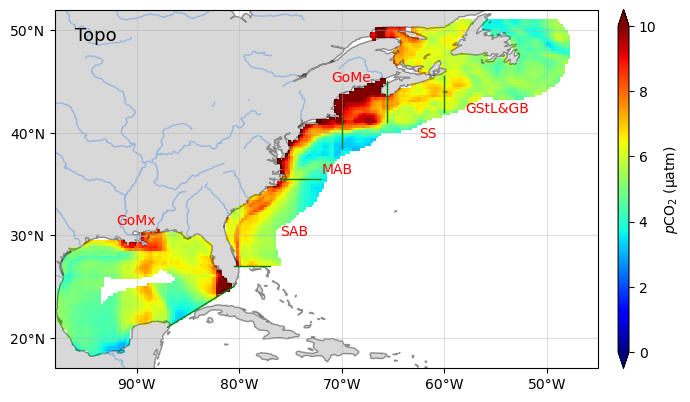

In [24]:
fig=plt.figure(figsize=(7,4.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(1,1),
                axes_pad=(0.7,0.7),
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='2%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 10), crs=projection)
    ax.set_yticks(np.arange(20,66, 10), crs=projection)

    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-45])
    ax.set_ylim([17,52])

    ax.plot([-80.5,-87],[25,21],c='g',linewidth=1) # GoMx & CbS
    ax.plot([-80.5,-77],[27,27],c='g',linewidth=1) # CbS & SAB
    ax.plot([-76,-72],[35.5,35.5],c='g',linewidth=1) # SAB & MAB
    ax.plot([-70,-70],[41.5,38.5],c='g',linewidth=1) # MAB & SS
    ax.plot([-65.6,-65.6],[41,45],c='g',linewidth=1) # SS & GoMa
    ax.plot([-60,-60],[42,45.5],c='g',linewidth=1) # SS & GStL

    ax.text(-58,42,'GStL&GB',c='r') 
    ax.text(-62.5,39.5,'SS',c='r') 
    ax.text(-71,45,'GoMe',c='r') 
    ax.text(-72,36,'MAB',c='r') 
    ax.text(-76,30,'SAB',c='r') 
    ax.text(-92,31,'GoMx',c='r') 
    if i == 0:
        p0 = ax.pcolor(lon_socat,lat_socat,np.nanmean(u_all,axis=(0,1)), transform=projection,clim=[0,10],cmap='jet')
        # ax.set_title('Difference between product and SOCAT $p$CO$_2$',fontdict={'size':12})
        # a = np.nanmean(np.nanmean(pco2_socat_4d,axis=0),axis=0)*mask_wide['mask_Atlantic'][0]
        # ax.text(-75,25,'mean $pCO_2$ = %.1f $\pm$ %.1f µatm' % (np.nanmean(a),np.nanstd(a)))
        ax.text(-96,49,'Topo',fontdict={'size':13})

    # ax.text(-100,53,chr(97+i),fontdict={'size':13,'weight':'bold'})
cb0 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='$p$CO$_2$ (µatm)')
# cb0.set_ticks(np.arange(-1000,1,100))
plt.tight_layout()

In [44]:
u_meas = np.full_like(u_inputs, 5.0)
u_meas = u_meas * mask_wide['mask_Atlantic'][0]

regions_list = ['mask_GStL','mask_SS','mask_GoMe','mask_MAB','mask_SAB','mask_GoMx','mask_Atlantic']
regions_name = ['GStL&GB','SS','GoMe','MAB','SAB','GoMx','NAACOM']

rmse_regions = {}

for mask_i in regions_list:
    y_obs = fco2_socat * mask_wide[mask_i][0]
    y_est = fco2_product * mask_wide[mask_i][0]
    ivalid = ~np.isnan(y_obs.flatten() * y_est.flatten())
    rmse_regions[mask_i] = rmse(y_obs.flatten()[ivalid], y_est.flatten()[ivalid])

u_grid = np.full_like(u_meas, -5.0).flatten()
u_model = np.full_like(u_meas, -5.0).flatten()


for mask_i in regions_list[:-1]:
    u_i = np.full(u_meas.shape, 1.0)
    u_i = u_i * mask_wide[mask_i][0] * rmse_regions[mask_i]
    ivalid = ~np.isnan(u_i.flatten())
    u_model[ivalid] = u_i.flatten()[ivalid].copy()

    u_i = np.full(u_meas.shape, 1.0)
    u_i = u_i * mask_wide[mask_i][0] * np.nanmean(fco2_socat_std * mask_wide[mask_i][0])
    ivalid = ~np.isnan(u_i.flatten())
    u_grid[ivalid] = u_i.flatten()[ivalid].copy()

u_grid[u_grid<0] = np.nan
u_grid = u_grid.reshape(u_meas.shape)
u_model[u_model<0] = np.nan
u_model = u_model.reshape(u_meas.shape)

u_all = np.sqrt(u_meas**2 + u_model**2 + u_grid**2 + u_inputs**2)

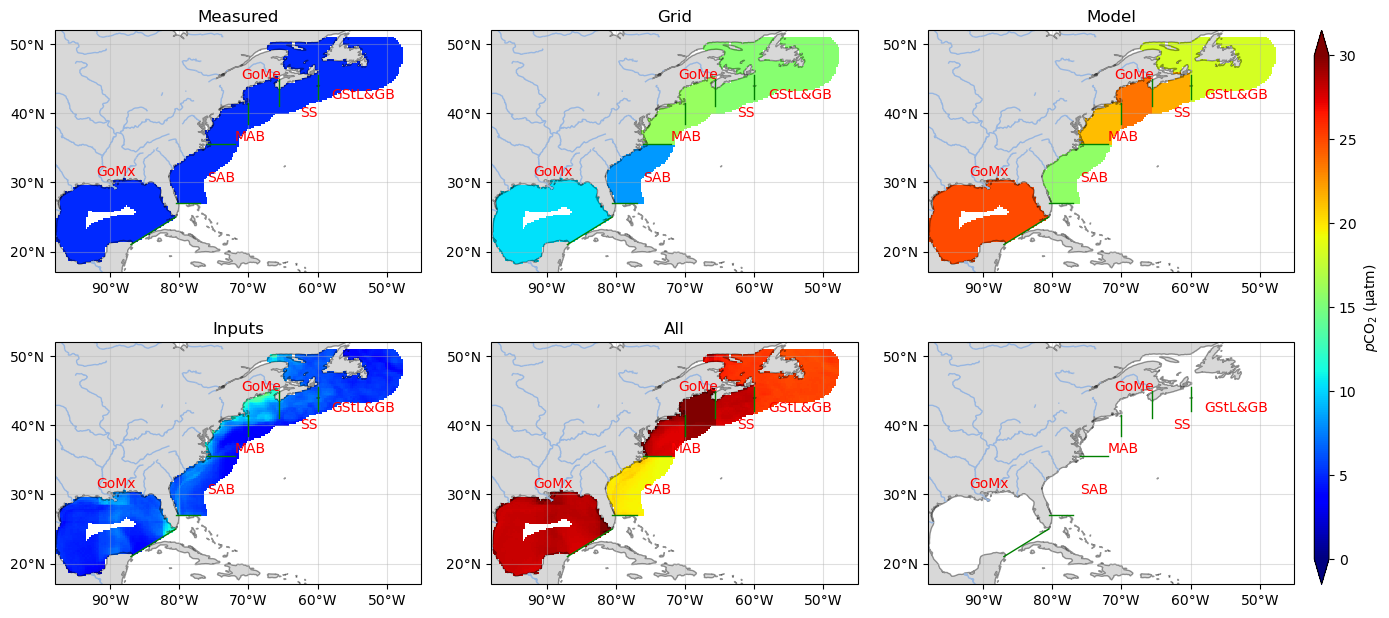

In [45]:
fig=plt.figure(figsize=(14,9))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2,3),
                axes_pad=(0.7,0.7),
                cbar_location='right',
                cbar_mode='single',
                cbar_pad=0.2,
                cbar_size='2%',
                label_mode='')  # note the empty label_mode
for i, ax in enumerate(axgr):
    ax.coastlines(alpha=0.4)
    ax.add_feature(cfeature.LAND,facecolor='grey',alpha=0.3)
    ax.add_feature(cfeature.RIVERS)
    ax.set_xticks(np.arange(-180,181, 10), crs=projection)
    ax.set_yticks(np.arange(20,66, 10), crs=projection)

    ax.grid('on',alpha=0.4)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlim([-98,-45])
    ax.set_ylim([17,52])

    ax.plot([-80.5,-87],[25,21],c='g',linewidth=1) # GoMx & CbS
    ax.plot([-80.5,-77],[27,27],c='g',linewidth=1) # CbS & SAB
    ax.plot([-76,-72],[35.5,35.5],c='g',linewidth=1) # SAB & MAB
    ax.plot([-70,-70],[41.5,38.5],c='g',linewidth=1) # MAB & SS
    ax.plot([-65.6,-65.6],[41,45],c='g',linewidth=1) # SS & GoMa
    ax.plot([-60,-60],[42,45.5],c='g',linewidth=1) # SS & GStL

    ax.text(-58,42,'GStL&GB',c='r') 
    ax.text(-62.5,39.5,'SS',c='r') 
    ax.text(-71,45,'GoMe',c='r') 
    ax.text(-72,36,'MAB',c='r') 
    ax.text(-76,30,'SAB',c='r') 
    ax.text(-92,31,'GoMx',c='r') 
    if i == 0:
        p0 = ax.pcolor(lon_socat,lat_socat,np.nanmean(u_meas,axis=(0,1)), transform=projection,clim=[0,30],cmap='jet')
        ax.set_title('Measured')
    elif i == 1:
        p1 = ax.pcolor(lon_socat,lat_socat,np.nanmean(u_grid,axis=(0,1)), transform=projection,clim=[0,30],cmap='jet')
        ax.set_title('Grid')
    elif i == 2:
        p2 = ax.pcolor(lon_socat,lat_socat,np.nanmean(u_model,axis=(0,1)), transform=projection,clim=[0,30],cmap='jet')
        ax.set_title('Model')
    elif i == 3:
        p3 = ax.pcolor(lon_socat,lat_socat,np.nanmean(u_inputs,axis=(0,1)), transform=projection,clim=[0,30],cmap='jet')
        ax.set_title('Inputs')
    elif i == 4:
        p4 = ax.pcolor(lon_socat,lat_socat,np.nanmean(u_all,axis=(0,1)), transform=projection,clim=[0,30],cmap='jet')
        ax.set_title('All')
    else:
        a = 0

    # ax.text(-100,53,chr(97+i),fontdict={'size':13,'weight':'bold'})
cb0 = axgr.cbar_axes[0].colorbar(p0,extend='both',label='$p$CO$_2$ (µatm)')
# cb0.set_ticks(np.arange(-1000,1,100))
plt.tight_layout()

In [51]:
regions_list = ['mask_GStL','mask_SS','mask_GoMe','mask_MAB','mask_SAB','mask_GoMx','mask_Atlantic']
regions_name = ['GStL&GB','SS','GoMe','MAB','SAB','GoMx','NAACOM']

u_grid_list = np.full(len(regions_list),np.nan)
u_meas_list = np.full(len(regions_list),np.nan)
u_model_list = np.full(len(regions_list),np.nan)
u_inputs_list = np.full(len(regions_list),np.nan)
u_all_list = np.full(len(regions_list),np.nan)

for i in range(len(regions_list)):
    mask_i = regions_list[i]
    u_meas_list[i] = 5.0
    u_grid_list[i] = np.nanmean(u_grid * mask_wide[mask_i][0])
    u_model_list[i] = np.nanmean(u_model * mask_wide[mask_i][0])
    u_inputs_list[i] = np.nanmean(u_inputs * mask_wide[mask_i][0])
u_all_list = np.sqrt(u_meas_list**2 + u_grid_list**2 + u_model_list**2 + u_inputs_list**2)

df_uncertainty = pd.DataFrame({'Region':regions_name,'u_meas':u_meas_list,'u_grid':u_grid_list,'u_model':u_model_list,'u_inputs':u_inputs_list,'u_all':u_all_list})
df_uncertainty.to_excel('uncertainty_table.xlsx')
df_uncertainty

,Region,u_meas,u_grid,u_model,u_inputs,u_all
0,GStL&GB,5.0,15.443203,18.195666,5.573524,25.012776
1,SS,5.0,15.366747,21.703920,6.175881,27.754974
2,GoMe,5.0,16.052767,23.305283,7.508970,29.702057
3,MAB,5.0,16.144128,21.219318,5.972255,27.776971
4,SAB,5.0,8.288902,15.777286,5.994930,19.456820
5,GoMx,5.0,10.377394,24.864491,5.551707,27.959876
6,NAACOM,5.0,12.690912,21.258089,5.864252,25.929810
